<a href="https://colab.research.google.com/github/Charan-14/Advanced_CNN/blob/main/RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the RetinaNet object detector model for this task since it has good accuracy results.

In [ ]:
!nvidia-smi

Tue Jul 28 08:30:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 5862, done.
remote: Total 5862 (delta 0), reused 0 (delta 0), pack-reused 5862
Receiving objects: 100% (5862/5862), 13.40 MiB | 20.73 MiB/s, done.
Resolving deltas: 100% (3948/3948), done.


In [ ]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 2.7MB/s 


In [ ]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170793 sha256=87f484e3b14f33084ee1bdd6dec694e58444258861c96acf6fd15536a65449f0
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=881f5863805a23ab1ab0f63ea5cb8ff38d7d1fb7ea046e339a66040b6531821d
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [ ]:
!pip install tensorflow-gpu==2.2.0

     |████████████████████████████████| 516.2MB 26kB/s 


In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [ ]:
import xml.etree.cElementTree as ET
import pandas as pd
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
#Converting XML Annotations to CSV for input into the Detector
def xmltocsv():

    path = "/content/drive/My Drive/Computer Vision Intern assigment/annotations"
    
    dfs = pd.DataFrame()
    for x in os.listdir(path):
        
        classes = []
        xmin = []
        ymin = []
        xmax = []
        ymax = []
        
        tree = ET.parse(os.path.join(path,x))
        root = tree.getroot()

        for element in root.findall("filename"):
            filename = element.text
            

        for element in root.findall("object"): 
            category = element.find("name").text
            classes.append(category)

            xmi = (element.find("bndbox")).find("xmin").text
            xmin.append(xmi)

            ymi = (element.find("bndbox")).find("ymin").text
            ymin.append(ymi)

            xma = (element.find("bndbox")).find("xmax").text
            xmax.append(xma)

            yma = (element.find("bndbox")).find("ymax").text
            ymax.append(yma)

       
        # dictionary of lists  
        content = {"Filename" : os.path.join("/content/drive/My Drive/Computer Vision Intern assigment/images",filename), "Xmin" : xmin, "Ymin" : ymin, "Xmax" : xmax, "Ymax" : ymax, "Class" : classes}  
        df = pd.DataFrame(content)
        dfs = dfs.append(df)
    
    # saving the dataframe 
    #dfs.drop(df.columns[[1]], axis=1, inplace = True)
    dfs.to_csv('Annotations.csv', index=False)
    
xmltocsv() 

In [ ]:
df = pd.read_csv("Annotations.csv")
df.head()


Filename  Xmin  ...  Ymax     Class
0  /content/drive/My Drive/Computer Vision Intern...   511  ...   676     crack
1  /content/drive/My Drive/Computer Vision Intern...  1039  ...   655     crack
2  /content/drive/My Drive/Computer Vision Intern...   333  ...   319     crack
3  /content/drive/My Drive/Computer Vision Intern...    58  ...   140     crack
4  /content/drive/My Drive/Computer Vision Intern...   171  ...   156  bullseye

[5 rows x 6 columns]

In [ ]:
#Visualizing the Dataset
def show_images(row):
    img_path = row.Filename
    bbox = [row.Xmin, row.Ymin, row.Xmax, row.Ymax]
    image = cv2.imread(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    draw_box(draw, bbox, color = (255,255,0))

    plt.axis('off')
    plt.imshow(draw)
    plt.show()


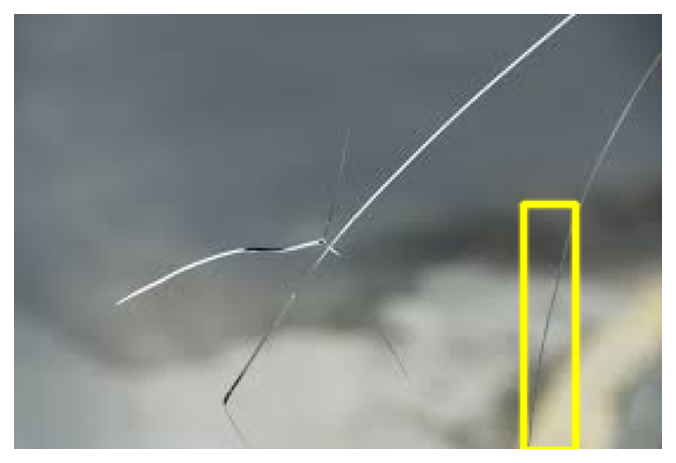

In [ ]:
show_images(df.iloc[61])

#Preprocessing


In [ ]:
#Splitting the dataset for training and validation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)


In [ ]:
train_df.head()

Filename  Xmin  ...  Ymax     Class
9   /content/drive/My Drive/Computer Vision Intern...     9  ...   160   scratch
5   /content/drive/My Drive/Computer Vision Intern...   310  ...   160   scratch
34  /content/drive/My Drive/Computer Vision Intern...   123  ...   108  bullseye
22  /content/drive/My Drive/Computer Vision Intern...   313  ...   151  bullseye
30  /content/drive/My Drive/Computer Vision Intern...    42  ...   120   scratch

[5 rows x 6 columns]

In [ ]:
#Creating and manipulating the classes file for input into the detector
ANNOTATIONS_FILE = "Annotations.csv"
CLASSES_FILE = "classes.csv"

train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)
classes = set(['scratch', 'bullseye', 'crack'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))



In [ ]:
!head classes.csv

bullseye,0
crack,1
scratch,2


In [ ]:
!head Annotations.csv

/content/drive/My Drive/Computer Vision Intern assigment/images/18.jpg,9,103,101,160,scratch
/content/drive/My Drive/Computer Vision Intern assigment/images/15.jpg,310,100,468,160,scratch
/content/drive/My Drive/Computer Vision Intern assigment/images/38.jpg,123,75,165,108,bullseye
/content/drive/My Drive/Computer Vision Intern assigment/images/31.jpg,313,40,451,151,bullseye
/content/drive/My Drive/Computer Vision Intern assigment/images/35.jpg,42,61,185,120,scratch
/content/drive/My Drive/Computer Vision Intern assigment/images/42.jpg,333,170,430,254,bullseye
/content/drive/My Drive/Computer Vision Intern assigment/images/41.jpg,156,53,251,83,scratch
/content/drive/My Drive/Computer Vision Intern assigment/images/25.jpg,575,236,869,465,bullseye
/content/drive/My Drive/Computer Vision Intern assigment/images/60.jpg,18,5,259,189,crack
/content/drive/My Drive/Computer Vision Intern assigment/images/54.jpg,363,145,471,236,bullseye


#Training


In [ ]:
PRETRAINED_MODEL = 'keras-retinanet/snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to keras-retinanet/snapshots/_pretrained_model.h5


In [ ]:
!keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 14 csv Annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
2020-07-28 08:36:49.516002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-28 08:36:49.577828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-28 08:36:49.578454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-07-28 08:36:49.578766: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-28 08:36:49.780924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07

#Loading trained model


In [ ]:
!ls snapshots

resnet50_csv_01.h5  resnet50_csv_04.h5	resnet50_csv_07.h5  resnet50_csv_10.h5
resnet50_csv_02.h5  resnet50_csv_05.h5	resnet50_csv_08.h5  resnet50_csv_11.h5
resnet50_csv_03.h5  resnet50_csv_06.h5	resnet50_csv_09.h5  resnet50_csv_12.h5


In [ ]:
model_path = "/content/drive/My Drive/resnet50_csv_14.h5"
model_path

'/content/drive/My Drive/resnet50_csv_14.h5'

In [ ]:
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [ ]:
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()


In [ ]:
labels_to_names

{0: 'bullseye', 1: 'crack', 2: 'scratch'}

#Predictions

In [ ]:
def predict(image):
    image = preprocess_image(image.copy())
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    boxes /= scale

    return boxes, scores, labels
    

In [ ]:
THRESH_SCORE = 0.4

def draw_detections(image, boxes, scores, labels):
    for box , score, label in zip(boxes[0], scores[0], labels[0]):
        if score <THRESH_SCORE:
            break
        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)    

        caption = "{} {:.3f}".format(labels_to_names[label],score)
        draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_row):
    img_path = image_row.Filename
  
    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [image_row.Xmin, image_row.Ymin, image_row.Xmax, image_row.Ymax]

    draw_box(draw, true_box, color=(255, 255, 0))

    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
test_df.head(n=15)

Filename  Xmin  ...  Ymax     Class
4   /content/drive/My Drive/Computer Vision Intern...   171  ...   156  bullseye
35  /content/drive/My Drive/Computer Vision Intern...   183  ...   184   scratch
10  /content/drive/My Drive/Computer Vision Intern...    55  ...   103  bullseye
0   /content/drive/My Drive/Computer Vision Intern...   511  ...   676     crack
45  /content/drive/My Drive/Computer Vision Intern...    15  ...   277  bullseye
47  /content/drive/My Drive/Computer Vision Intern...    12  ...   190     crack
66  /content/drive/My Drive/Computer Vision Intern...    85  ...    71  bullseye
53  /content/drive/My Drive/Computer Vision Intern...    11  ...   548   scratch
50  /content/drive/My Drive/Computer Vision Intern...    48  ...   352     crack
28  /content/drive/My Drive/Computer Vision Intern...    53  ...   127   scratch
68  /content/drive/My Drive/Computer Vision Intern...   499  ...   396  bullseye
74  /content/drive/My Drive/Computer Vision Intern...   873  ...   460   scratch
18  /content/drive/My Drive/Computer Vision Intern...   867  ...  1183  bullseye
12  /content/drive/My Drive/Computer Vision Intern...   453  ...   370  bullseye
58  /content/drive/My Drive/Computer Vision Intern...     3  ...   169   scratch

[15 rows x 6 columns]

#Results

Yellow - Ground Truth Box

---


Other Colors - Predictions

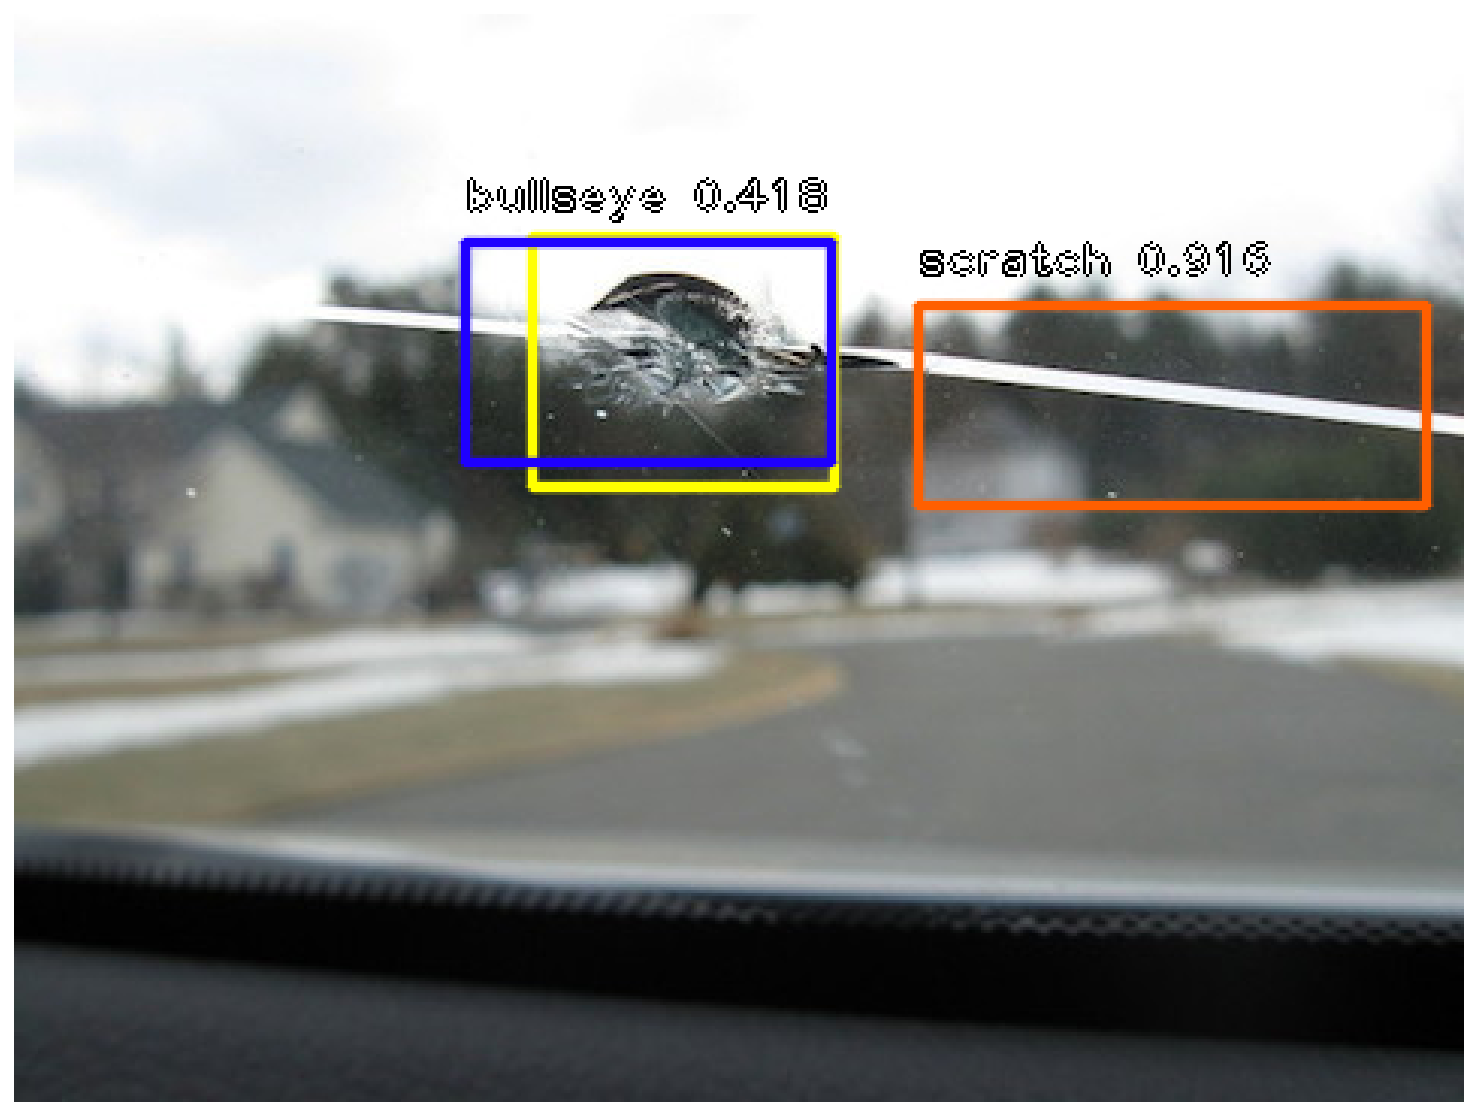

In [ ]:
show_detected_objects(test_df.iloc[0])

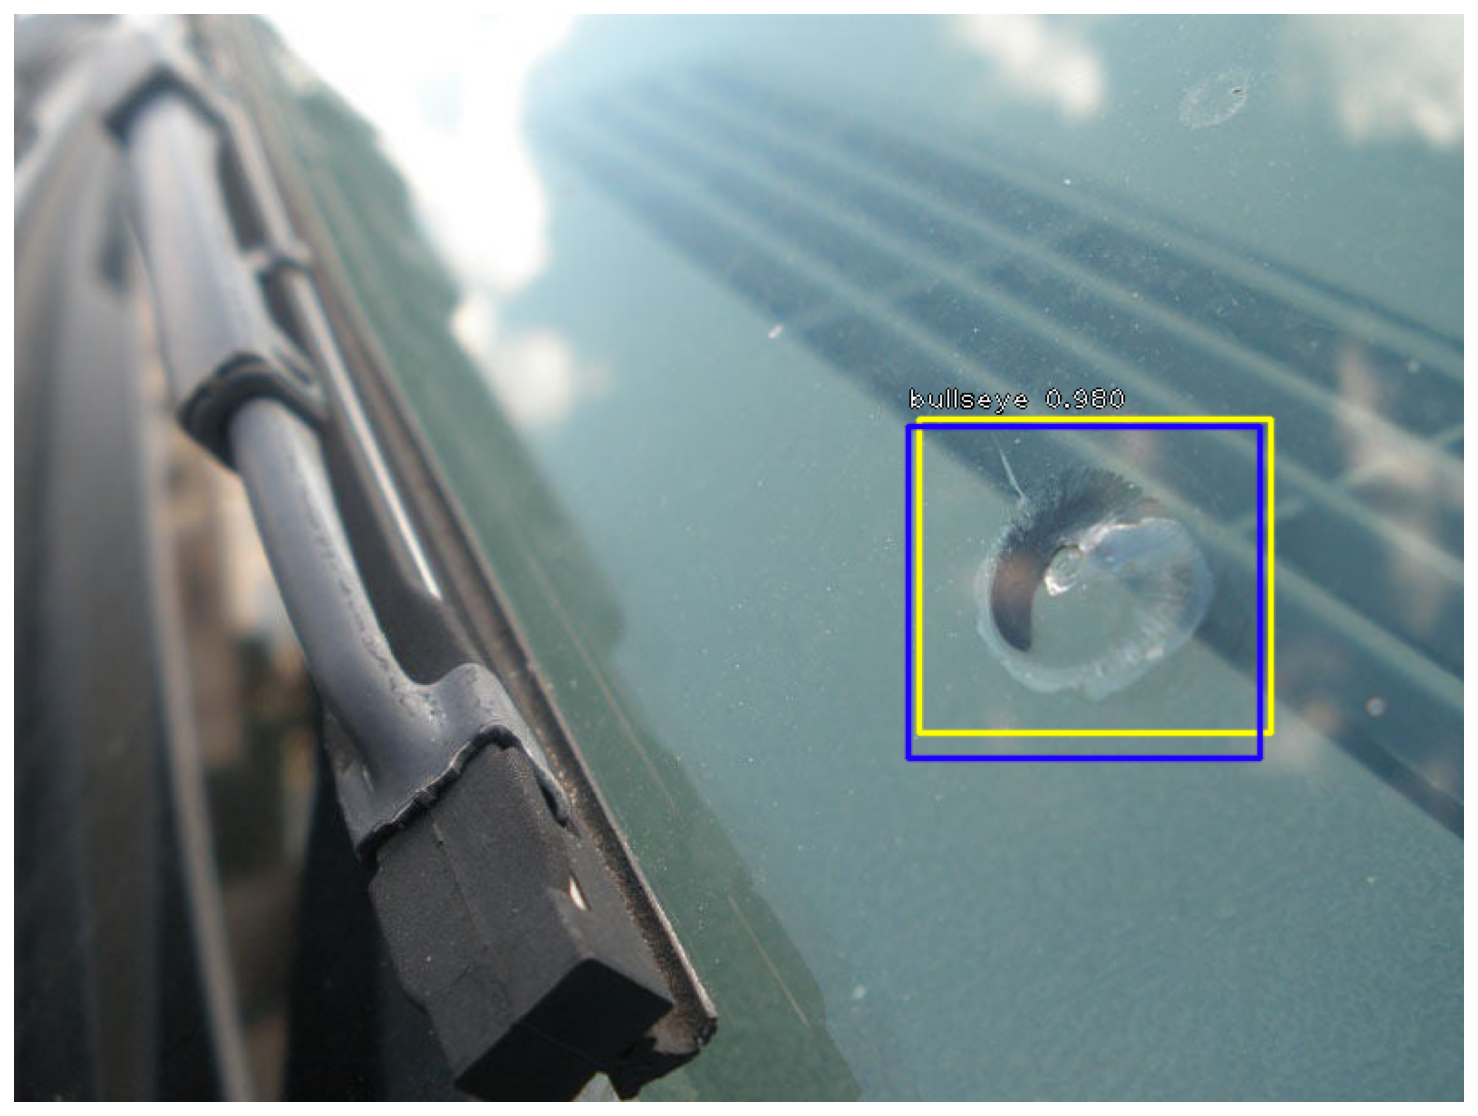

In [ ]:
show_detected_objects(test_df.iloc[10])

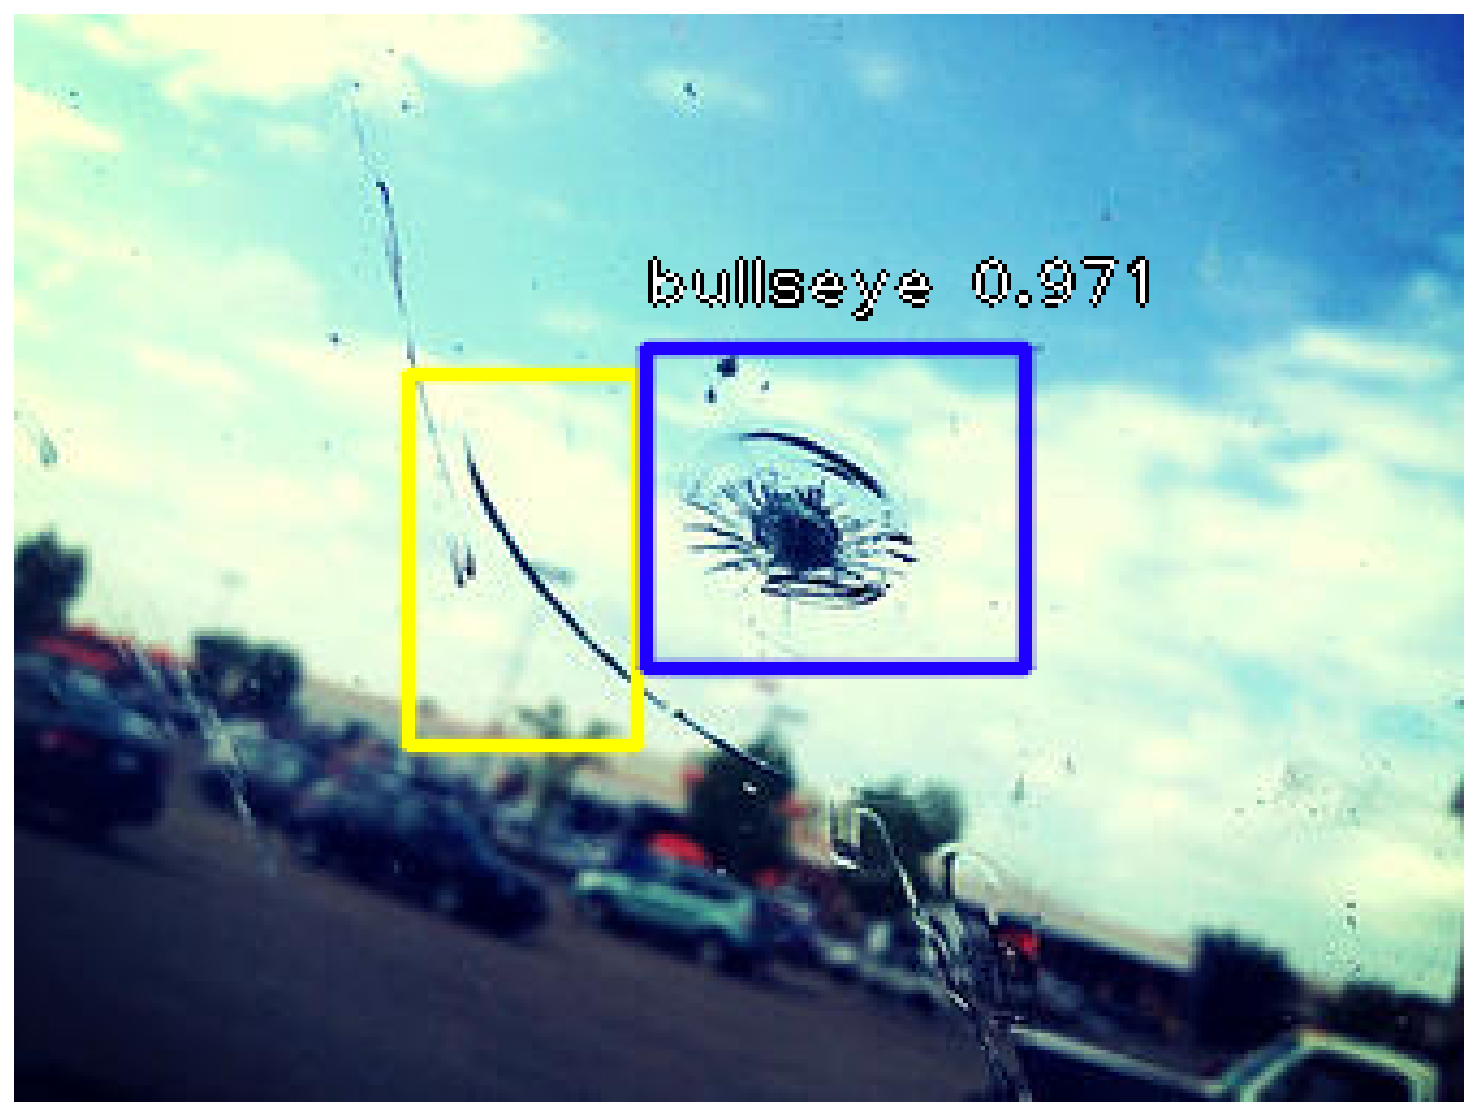

In [ ]:
show_detected_objects(test_df.iloc[15])

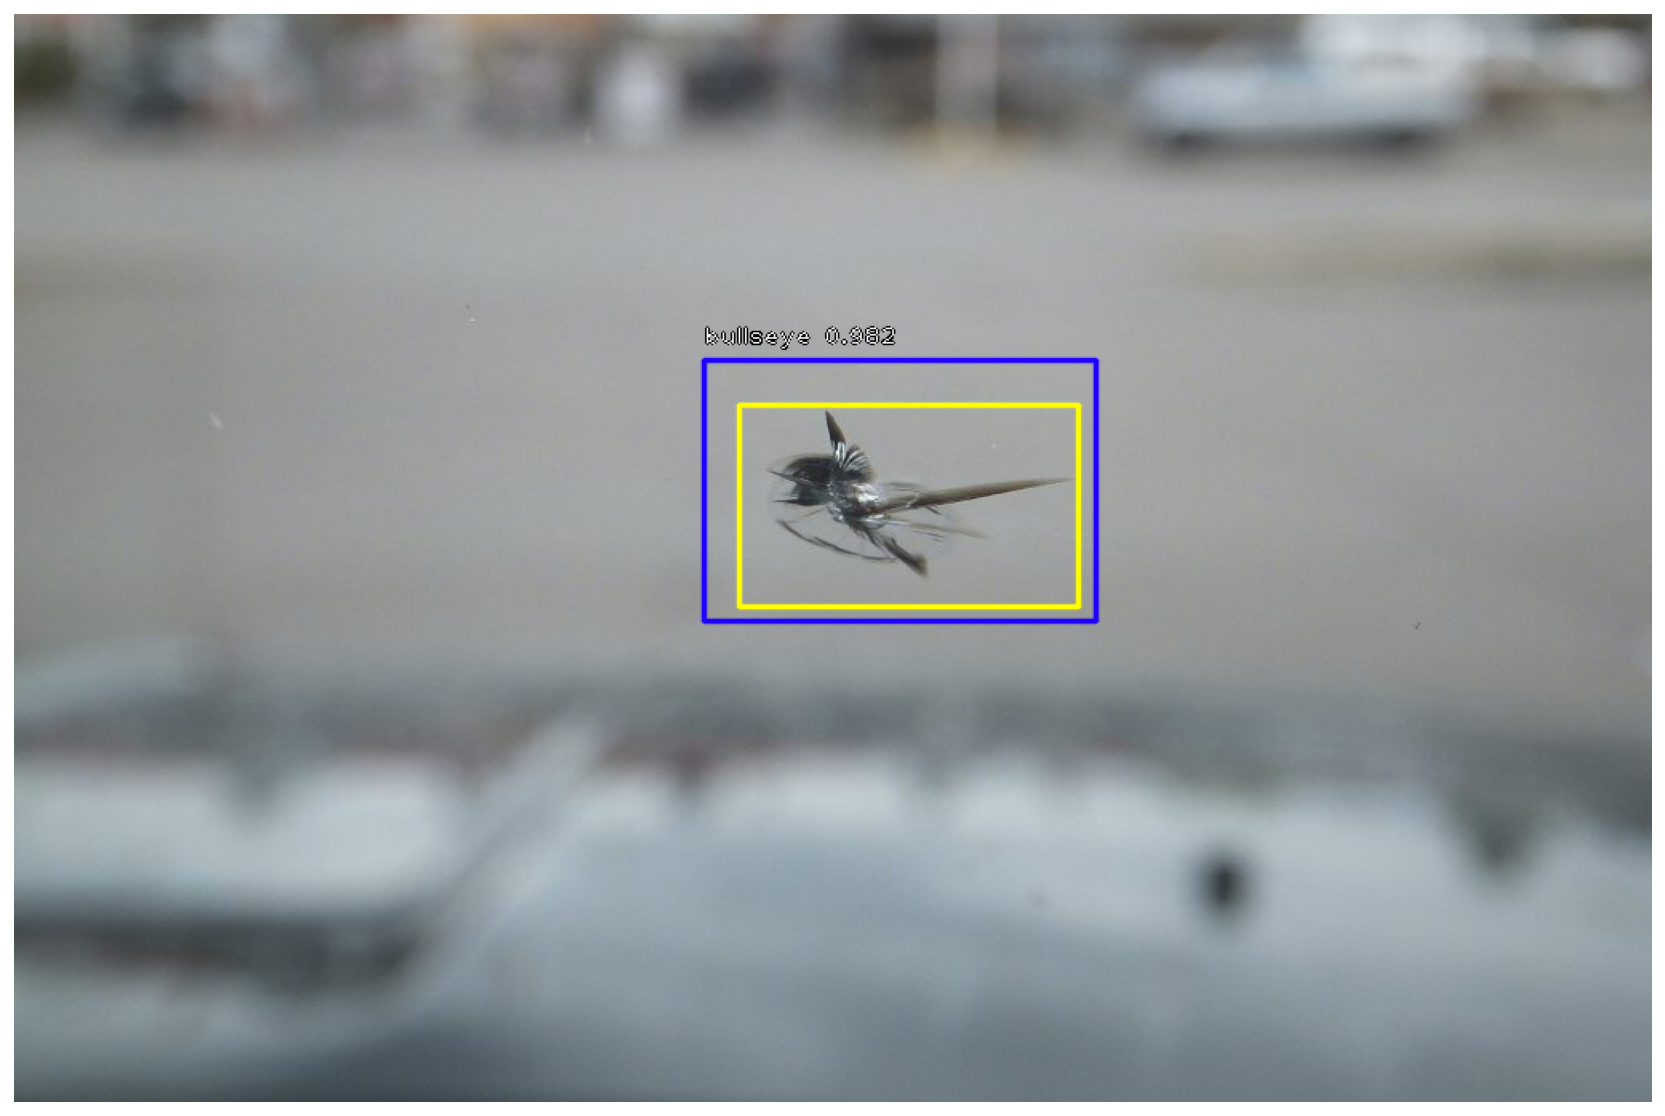

In [ ]:
show_detected_objects(test_df.iloc[13])

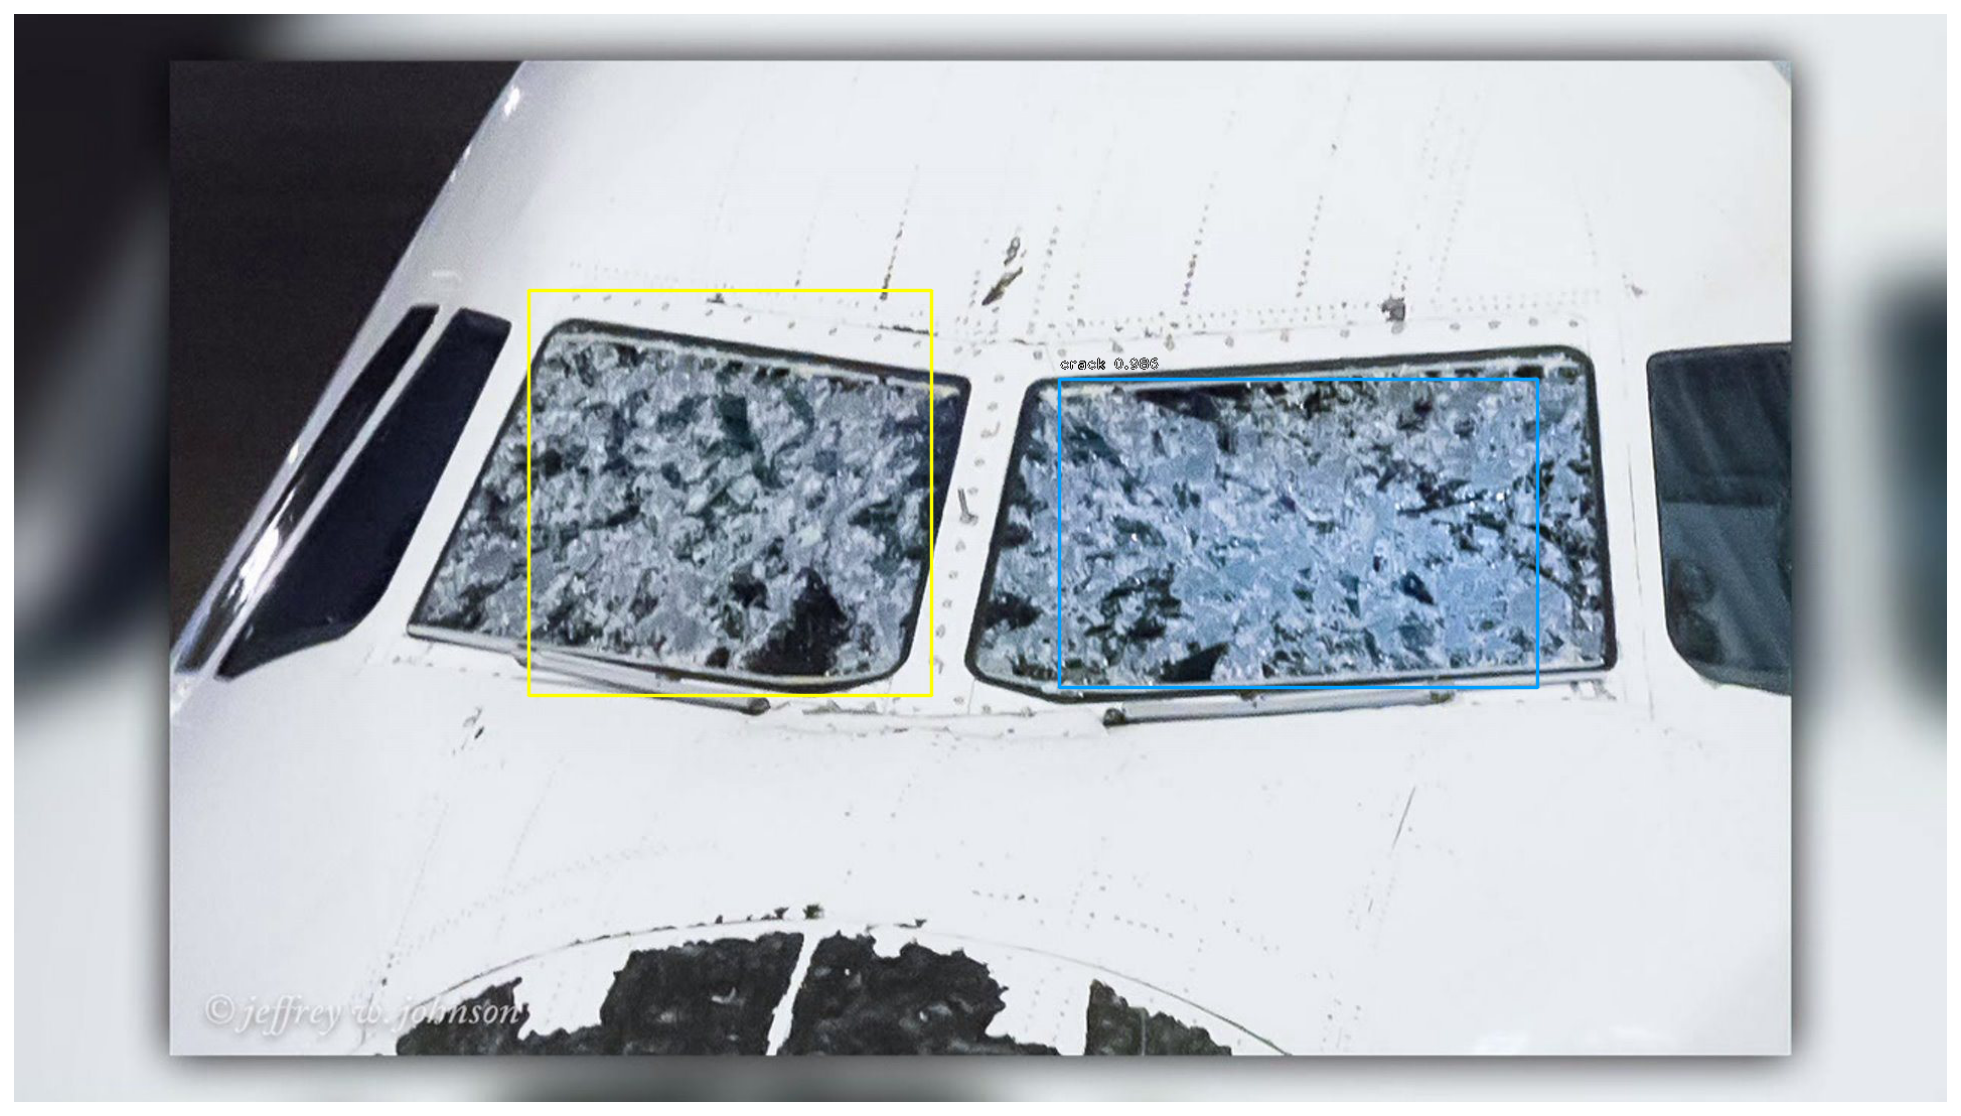

In [ ]:
show_detected_objects(test_df.iloc[3])

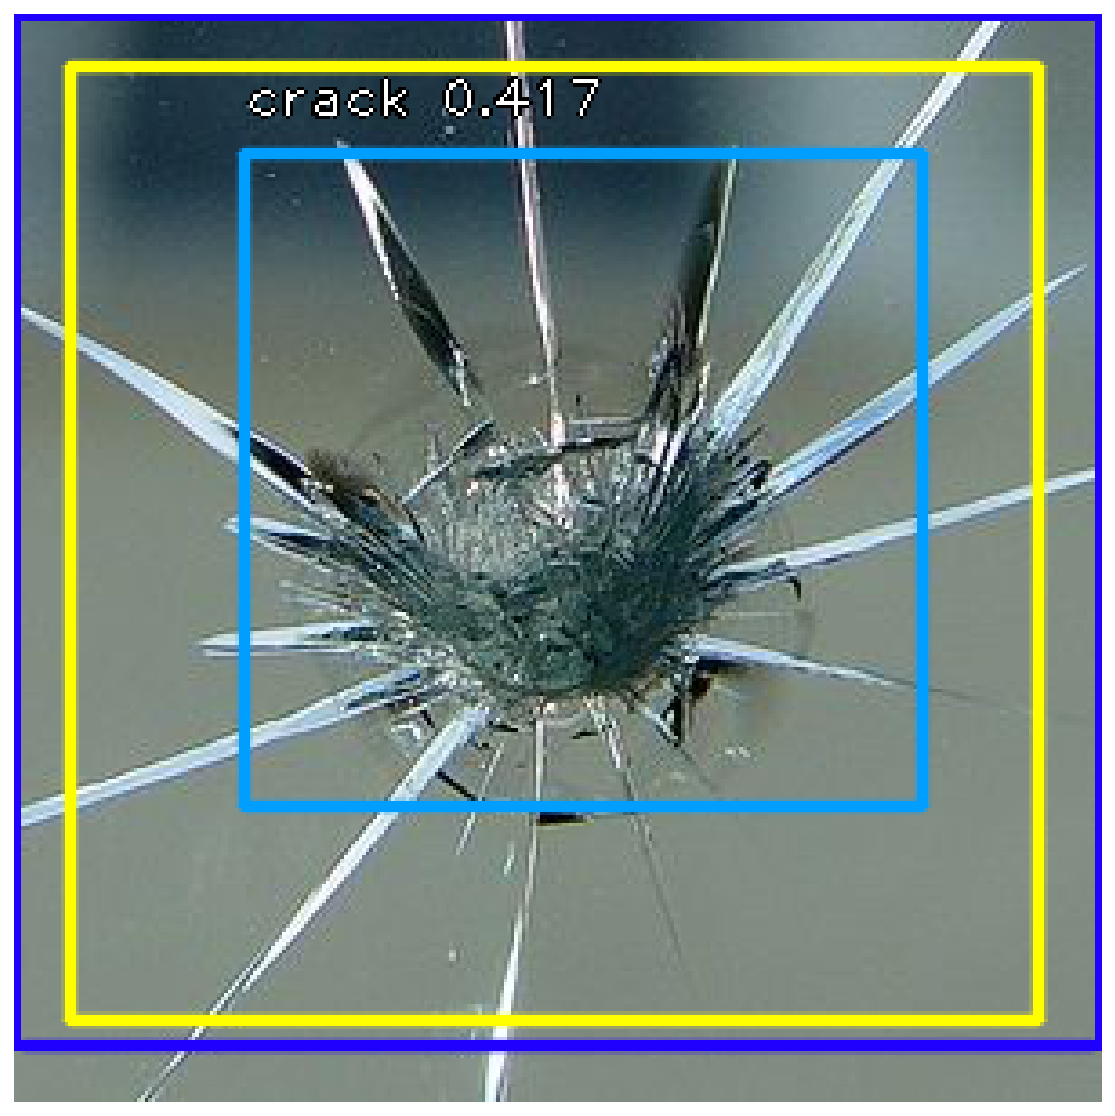

In [ ]:
show_detected_objects(test_df.iloc[4])

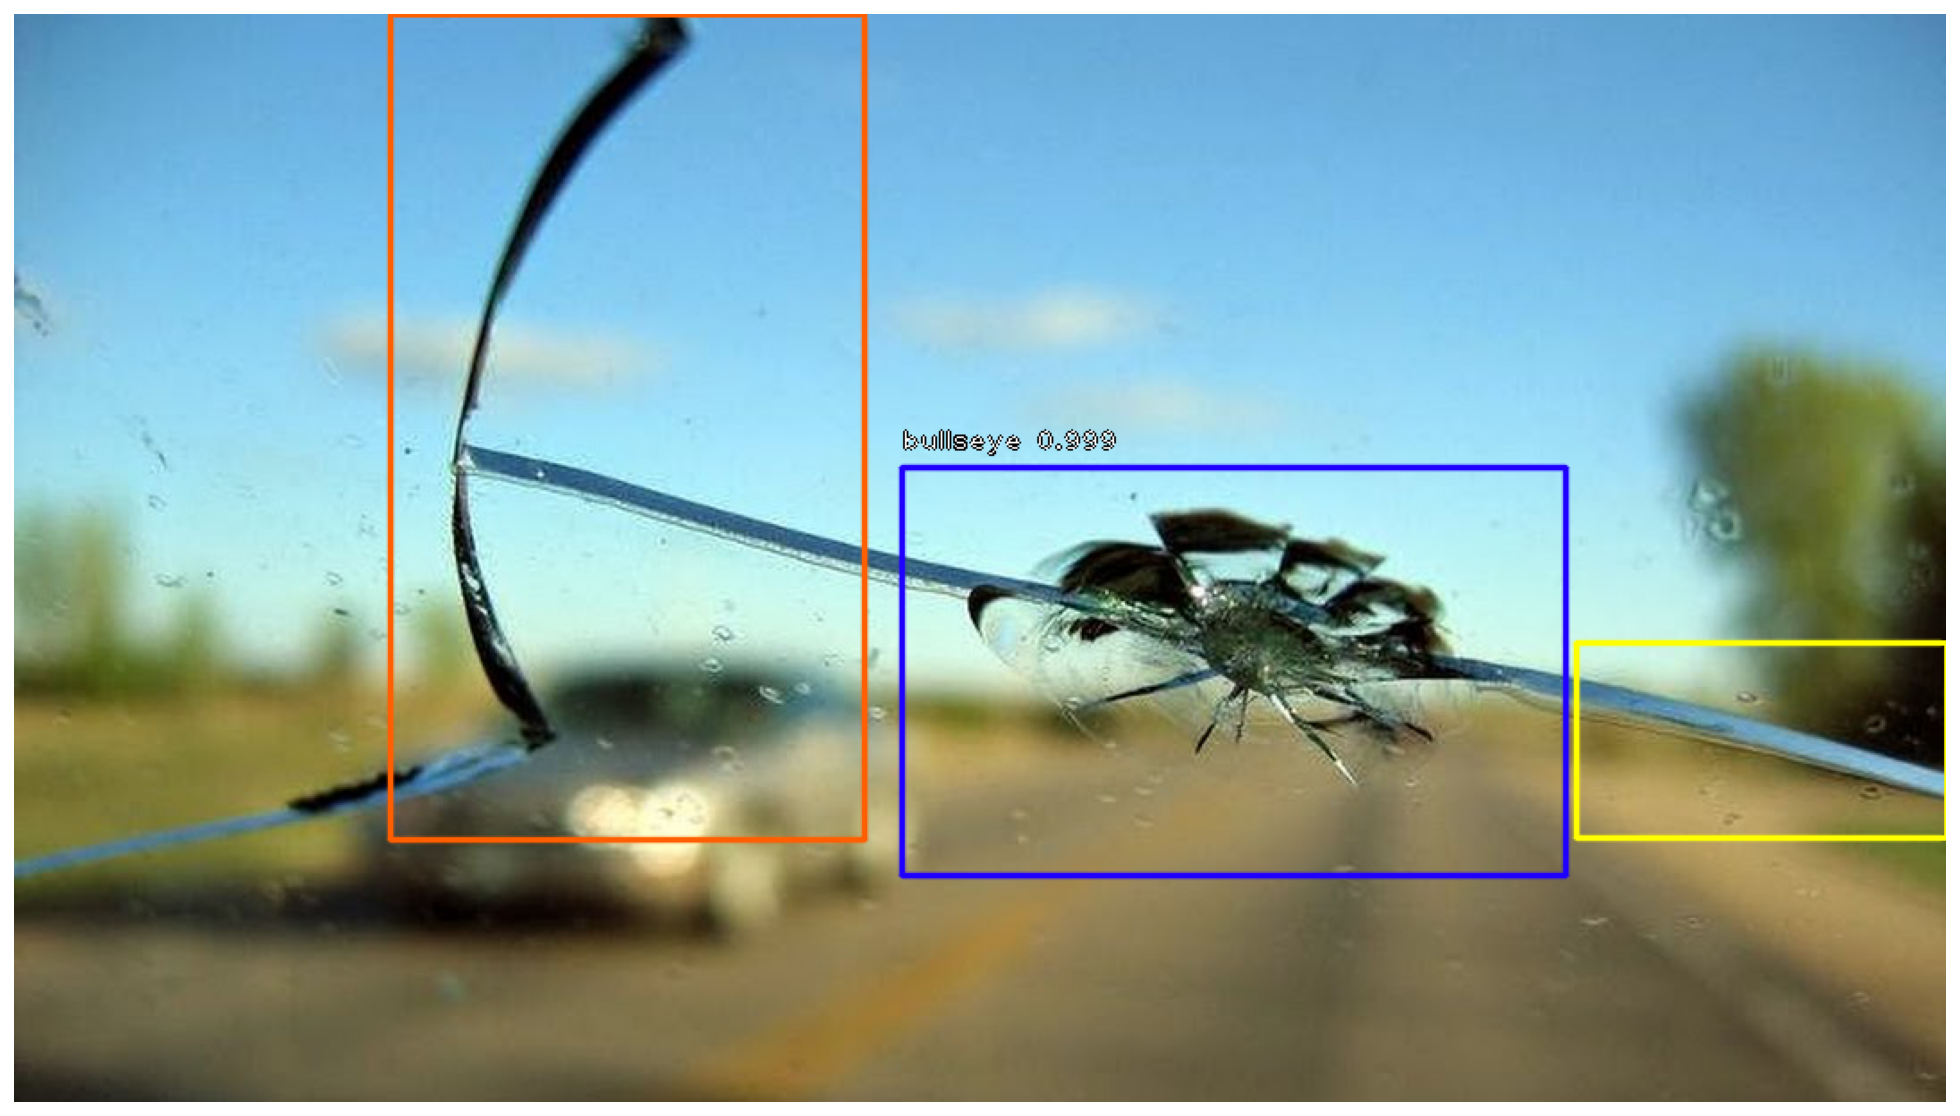

In [ ]:
show_detected_objects(test_df.iloc[11])

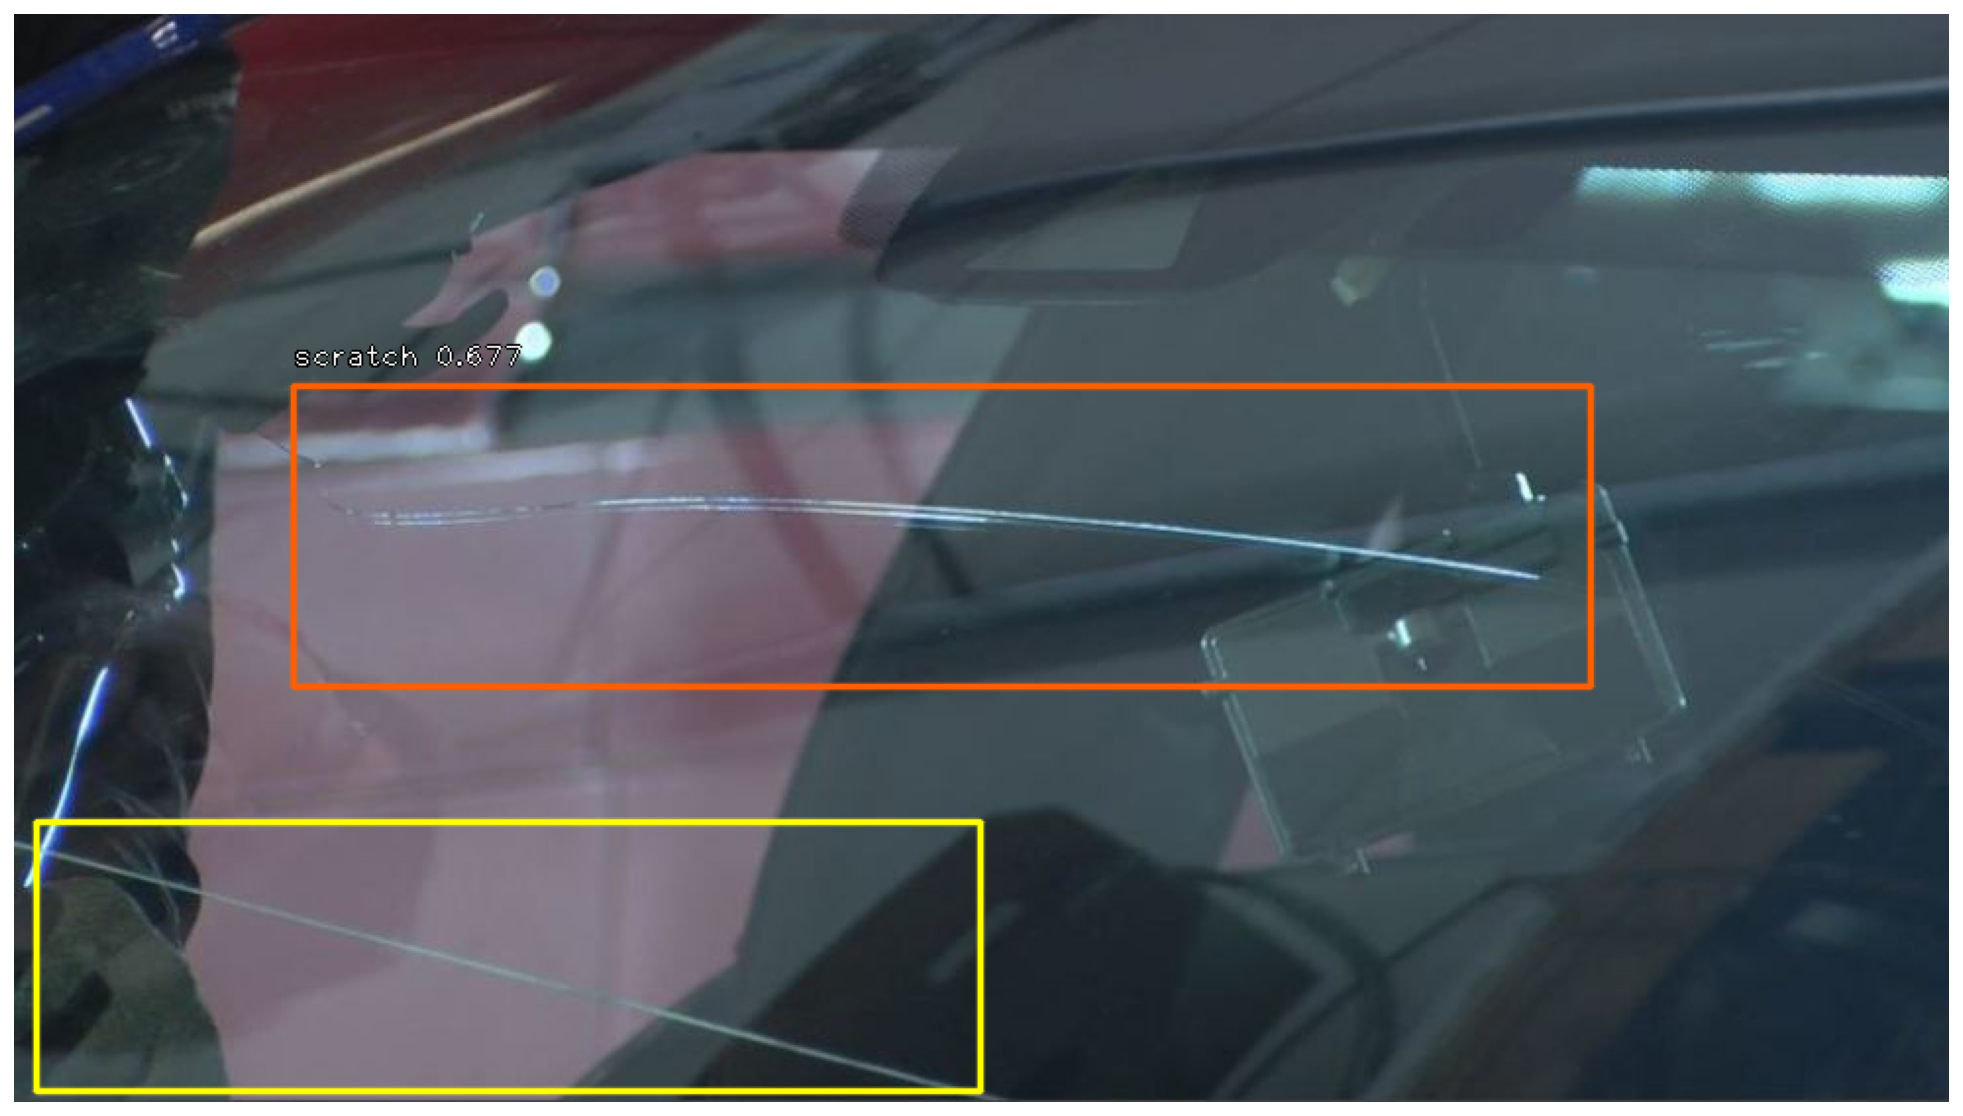

In [ ]:
show_detected_objects(test_df.iloc[7])